K-Means


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

print("Libraries loaded successfully.")




Libraries loaded successfully.


Data Loading & Cleaning

In [9]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)


Elbow Method

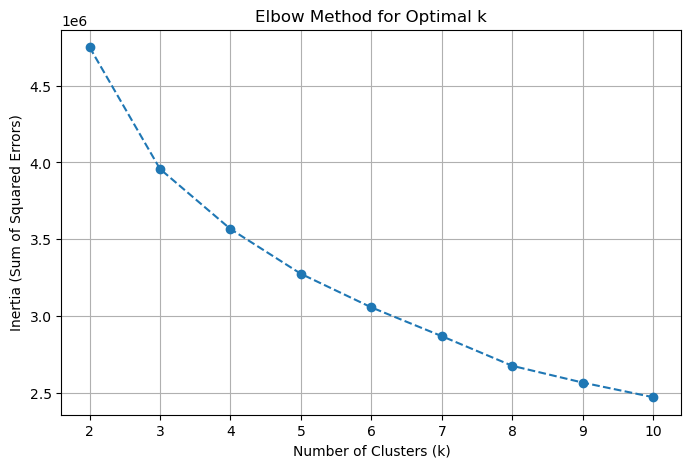

In [8]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

K-Means Algorithm Implementation

In [ ]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids



Application

In [ ]:
#I choose k based on the Elbow Plot 
k_optimal = 4
max_iters = 10

#Sampling
#I take a random sample of 10,000 movies to make the assignment runnable in Colab because we hace 1 million rows
if X_scaled.shape[0] > 10000:
    np.random.seed(42) # For reproducibility
    #random indices
    indices = np.random.choice(X_scaled.shape[0], 10000, replace=False)
    X_sample = X_scaled[indices]
    #We also save the original data for this sample to interpret later
    df_sample = df.iloc[indices].copy()
    print(f"Dataset is large. Using a random sample of {X_sample.shape[0]} movies for manual execution.")
else:
    X_sample = X_scaled
    df_sample = df.copy()

#Randomly pick k points from our sample to be the starting centroids
random_indices = np.random.choice(X_sample.shape[0], k_optimal, replace=False)
centroids = X_sample[random_indices]

assignments = np.zeros(X_sample.shape[0])

print(f"\nStarting Manual K-Means Algorithm (k={k_optimal})...")

#K means
for i in range(max_iters):
    print(f"Iteration {i+1}/{max_iters}...")
    
    #Assign points to clusters 
    assignments = find_closest_centroids(X_sample, centroids)
    
    #Calculate new centroids
    previous_centroids = centroids
    centroids = compute_centroids(X_sample, assignments, k_optimal)
    
    #Check for convergence (if centroids don't change, we stop)
    if np.all(centroids == previous_centroids):
        print("Converged early!")
        break

print("Manual Clustering Completed Successfully.")

Dataset is large. Using a random sample of 10000 movies for manual execution.

Starting Manual K-Means Algorithm (k=4)...
Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...
Manual Clustering Completed Successfully.


Visualization and analysis

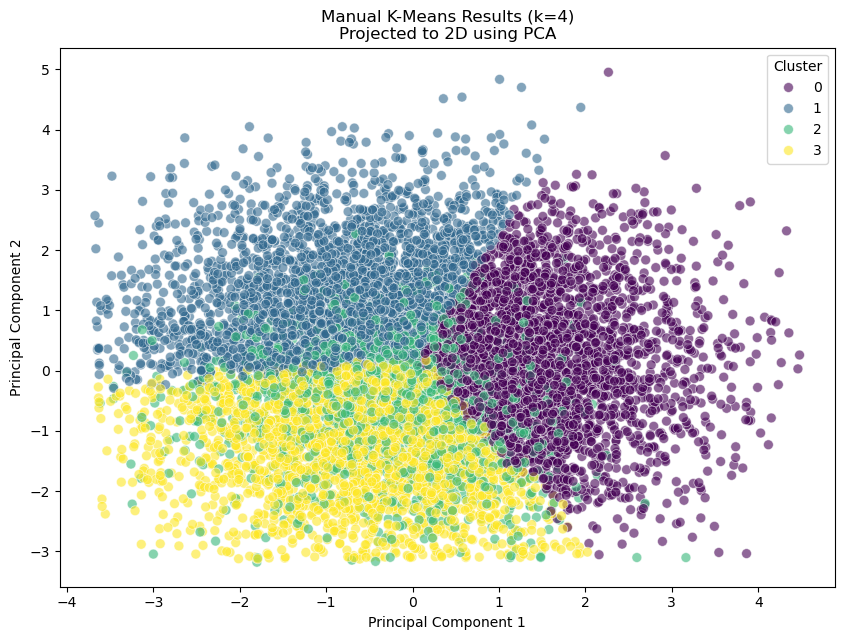


--- Cluster Profiles (Average Values) ---
            BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore
Cluster                                                                    
0        2.640391e+07         7.430994e+07    6.280479            62.720684
1        2.166725e+06         5.320622e+06    5.073951            47.874523
2        4.103586e+06         1.051831e+07    6.962480            70.076964
3        2.752309e+06         7.108061e+06    7.829435            80.505809

Movies per Cluster:
 Cluster  NumMovies
       0       2925
       1       2622
       3       2582
       2       1871


In [16]:
#VISUALIZATION (PCA 2D)
#We use PCA only to project the 6-dimensional data onto a 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=assignments, 
    palette='viridis', 
    s=50, 
    alpha=0.6
)
plt.title(f'Manual K-Means Results (k={k_optimal})\nProjected to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#CLUSTER PROFILING
#Add the cluster labels to our sample dataframe
df_sample['Cluster'] = assignments

#Calculate the mean of the original features for each cluster
# Note: We use the original columns (before scaling) to make it readable (e.g. real dollars)
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster')[numeric_cols].mean()

print("\n--- Cluster Profiles (Average Values) ---")
print(profile)

#how many movies are in each cluster
print("\nMovies per Cluster:")
df_counts = df_sample['Cluster'].value_counts().reset_index()
df_counts.columns = ['Cluster', 'NumMovies']
print(df_counts.to_string(index=False))

